In [1]:
import math
import torch
from torch import nn
from torch import Tensor
from torch.nn  import functional as F
import gpytorch
from matplotlib import pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D 
import sys
from decimal import Decimal
sys.path.append("..")
import vvkernels as vvk
import sep_vvkernels as svvk
import vvk_rbfkernel as vvk_rbf
import vvmeans as vvm
import vvlikelihood as vvll
from objfun import ObjFun
from LBFGS import FullBatchLBFGS
import numpy as np
import seaborn as sns
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
vf = ObjFun()
f_target = vf.tgt_vec
sample_size = 24
D = vf.D
N = vf.N

vf.low = -3.
vf.high = 3.

high_minus_low = vf.high- vf.low
def g_theta(sample_size, D):
    loc = high_minus_low  * np.random.random_sample((sample_size,2)) + vf.low#(np.random.uniform(low=vf.low, high=vf.high, size=(sample_size, D)))
    return Tensor(loc)
train_x = g_theta(sample_size, D)
train_y = torch.zeros([sample_size, N])

train_y = (vf(train_x[:,0], train_x[:,1]))# + torch.randn(Tensor(vf(train_x[:,0], train_x[:,1])).size()) * 0.2
print(train_y)

tensor([[ 1.4793e+00, -7.6265e-01],
        [-2.3085e+00,  1.2885e-01],
        [-1.3433e+00,  5.4307e-01],
        [-1.1503e+00,  3.2058e+00],
        [ 1.3703e+00, -4.0900e-04],
        [ 2.7439e+00, -4.1150e+00],
        [-9.6326e-01,  2.8741e-02],
        [-3.5787e+00,  1.0053e+00],
        [-2.8142e+00,  9.1296e-02],
        [-2.0945e+00,  6.0390e-02],
        [ 4.1084e+00, -8.2734e-04],
        [ 1.0053e+00,  2.2216e+00],
        [ 7.8097e+00, -3.7833e+00],
        [ 3.8022e+00,  4.9679e-01],
        [ 8.8737e+00, -4.7752e+00],
        [ 3.2249e-01, -5.1640e-01],
        [-4.8150e+00,  1.3829e+00],
        [-1.7368e+00,  1.7084e-01],
        [ 2.9849e+00, -4.3727e+00],
        [-2.8157e+00,  2.8005e-01],
        [ 4.0607e+00, -6.4976e+00],
        [-1.5606e-01,  2.1130e+00],
        [-8.2912e-02, -2.3088e-01],
        [ 1.5689e+00,  7.5882e-01]])


In [3]:
def vfield_(x):
    x = x.reshape(x.shape[0],D)
    out = torch.zeros(x.shape[0], N)
    out = vf(x[:,0], x[:,1]) #+ torch.randn(Tensor(vf(x[:,0], x[:,1])).size()) * 0.2
#     for i in range(x.shape[0]):
#         out[i] = Tensor(vf(x[i])) #+ torch.randn(Tensor(vf(x[i])).size()) * 0.1
    return out

train_y = vfield_(train_x)

# Objective function

We sample from $$V_1(x_1, x_2) = 3(1 - x_1)^2 e^{-x_1^2 - (x_2 +1)^2} - 10 (x_1/5 - x_1 ^3 - x_2^5) e^{-x_1^2 - x_2 ^2} - 3 e^{- (x_1 + 2) ^2 - x_2^2} + 0.5(2x_1 + x_2)$$
$$V_2(x_1, x_2) = 3(1 +x_2)^2 e^{-x_2^2 - (x_1 +1)^2} - 10 (-x_2/5 + x_2 ^3 + x_1^5) e^{-x_1^2 - x_2 ^2} - 3 e^{- ( 2- x_2) ^2 - x_1^2} + 0.5(2x_1 + x_2)$$

where $(x_1, x_2) \in [-3, 3]^2$

In [4]:
def stopping_criteria(tol_vector, f_target, lower_bound, upper_bound):
    lower_tol_vector = f_target - tol_vector
    upper_tol_vector = f_target + tol_vector
    SUCCESS = True
    FAILURE = False
    for i in range(f_target.shape[0]):
            if (lower_bound[i] < lower_tol_vector[i]) or  (upper_bound[i] > upper_tol_vector[i]):
                SUCCESS = False  
            if ((lower_bound[i] > upper_tol_vector[i]) or  (upper_bound[i] < lower_tol_vector[i])):
                FAILURE = True
    return SUCCESS, FAILURE

In [5]:

x_train = train_x #loc #torch.linspace(0, 1, 10)
y_train = train_y #v  #torch.stack([torch.sin(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * 0.2,torch.cos(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * 0.2,], -1)

class MultitaskGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood,num_base_kernels):
        super(MultitaskGPModel, self).__init__(train_x, train_y, likelihood)
        a = torch.ones(2,2)
        chol_q = torch.tril(a)
        self.mean_module =vvm.TensorProductSubMean(gpytorch.means.LinearMean(2), num_tasks = 2)#vvm.TensorProductSubMean(gpytorch.means.ConstantMean(), num_tasks = 2)  # 
        base_kernels = []
        for i in range(num_base_kernels):
            base_kernels.append((vvk_rbf.vvkRBFKernel())) #gpytorch.kernels.PolynomialKernel(4)  ##gpytorch.kernels.MaternKernel()# (vvk_rbf.vvkRBFKernel())
#         base_kernels2 = []
#         for i in range(num_base_kernels):
#             base_kernels2.append(gpytorch.kernels.PolynomialKernel(5))  
            
        self.covar_module = svvk.SepTensorProductKernel(base_kernels,num_tasks = 2)

#\         self.covar_module = gpytorch.kernels.MultitaskKernel(
#             gpytorch.kernels.RBFKernel(), num_tasks=2, rank=1
#         )
       # self.covar_module = vvk.TensorProductKernel(vvk_rbf.vvkRBFKernel(), a[0,0], a[1,0], a[1,1], num_tasks = 2, rank =1,  task_covar_prior=None)

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x,x)
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)
    
    



In [6]:
def hyper_opti(g_theta1, agg_data, training_iter,num_base_kernels,noise_value, current_model = None, current_likelihood = None):
  
    noises = torch.ones(agg_data.shape[0]) *noise_value #  torch.zeros(agg_data.shape[0]) # 

    
   # ii = 0
#     if (current_model is not None):
#         likelihood = current_likelihood #vvll.FixedNoiseMultitaskGaussianLikelihood(2, noises) #vvll.FixedNoiseMultitaskGaussianLikelihood(2, noises)  #

#         model = current_model#.get_fantasy_model(g_theta1, agg_data) #MultitaskGPModel(g_theta1, agg_data, likelihood,num_base_kernels)
#         model.set_train_data(g_theta1, agg_data,  strict=False)
#     else:
#         likelihood = vvll.FixedNoiseMultitaskGaussianLikelihood(2, noises)
#         model = MultitaskGPModel(g_theta1, agg_data, likelihood,num_base_kernels)
        
    likelihood = vvll.FixedNoiseMultitaskGaussianLikelihood(2, noises)
    model = MultitaskGPModel(g_theta1, agg_data, likelihood,num_base_kernels)    
    model.train()
    likelihood.train()
    optimizer = FullBatchLBFGS(model.parameters(), lr=1.)
 #\   mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
    def closure():
        
        optimizer.zero_grad()
#         output = model(g_theta1)
#         output_ll = likelihood(output)

        loss, inv_quad = likelihood.get_mll(agg_data,g_theta1, model, likelihood, noise_value)
        loss = -loss
        #loss = -mll(output, agg_data)
        print('Loss gp: %.3f' % ( loss))
        print('inv_quad: %.3f' % ( inv_quad))
        return loss
    
    loss = closure()
    loss.backward()

    for i in range(training_iter):
        options = {'closure': closure, 'current_loss': loss, 'max_ls': 10}
        loss, _, _, _, _, _, _, fail = optimizer.step(options)

        if fail:
            print('Convergence reached!')
            break
        #print(i)
    return model, likelihood

In [7]:
class design_opti(nn.Module):
    def __init__(self, sample, x):
        super(design_opti, self).__init__()
        #loc = np.random.random_sample((loc_size,2))
        self.g_theta2 = nn.Parameter(Tensor(sample))
        self.x_design = nn.Parameter(Tensor(x))
    def forward(self):
       
        g_theta2_new = self.g_theta2 #filter_sample(self.g_theta2, 0.009)
        
        return (g_theta2_new), self.x_design

In [8]:
def conduct_design_opti(x0,loc_sample, f_target, g_theta1, agg_data, model, likelihood, training_design_iter, training_param_iter, lr_new,noise_value):
    design = design_opti(loc_sample,x0)
    loc_sample0 = loc_sample
    
    g_theta2, x_d = design.forward()
    def closure():
        optimizer.zero_grad()
        
        loss2,lower_bound, upper_bound = likelihood.get_ell(agg_data,f_target,x_d, g_theta1, g_theta2, model, likelihood, noise_value)
        loss2 = -1. * loss2
        loss2.backward(retain_graph = True)
#         print(x_d)
#         print(lower_bound)
#         print(upper_bound)
       
        return loss2
        
        
        
    optimizer = torch.optim.LBFGS(design.parameters(), lr=lr_new, history_size=100, max_iter=100, line_search_fn="strong_wolfe")
    optimizer.step(closure)

    g_theta2, x_d = design.forward()
    loss2,lower_bound, upper_bound = likelihood.get_ell(agg_data,f_target,x_d, g_theta1, g_theta2, model, likelihood, noise_value)
    loss2 = -1. * loss2
    print('Loss design: %.3f' % ( loss2))
    #print(x_d)
    return x_d, g_theta2, lower_bound, upper_bound, loss2
    
    

In [9]:
iter_hp = 50
iter_design = 40 
iter_param = 50
num_base_kernels = 5


f_target = Tensor(vf.tgt_vec) 
f_target = f_target.reshape(f_target.shape[0],1) 
tol_vector = 0.005 * torch.ones(f_target.shape)


loc_size = 4
loc_sample = high_minus_low  * np.random.random_sample((loc_size,2)) + vf.low #np.random.random_sample((loc_size,2))
g_theta2_vec = (Tensor(loc_sample).clone()).flatten()

g_theta1 = x_train
agg_data = y_train.flatten()


x0 = Tensor(np.array([0.0,0.0])) 
x0 = x0.reshape(1,2)
x00 = x0 
vec_x = Tensor(np.array([0.0,0.0])) 
vec_x = vec_x.reshape(1,2)

lr_new = 1.
noise_value = 0.0 #1e-6


SUCCESS = False 
FAILURE = False 
iter = 0 
tol = 0.009 
while(SUCCESS == False and iter < 100):
    print(iter)
    print('START HYPERPARAMETERS optimization')
    if (iter == 0):
        cur_model = None
        cur_likelihood = None
        
    model, likelihood = hyper_opti(g_theta1,agg_data,iter_hp,num_base_kernels,noise_value, current_model = cur_model, current_likelihood = cur_likelihood)
#     for param_name, param in model.named_parameters():
#         print(param_name)
#         print(param)

    print('END HYPERPARAMETERS optimization')
    print(g_theta1.shape)
    

    x0_new,g_theta2,lower_bound, upper_bound, loss = conduct_design_opti(x0, loc_sample, f_target, g_theta1, agg_data, model, likelihood, iter_design,iter_param, lr_new,noise_value)
    cur_model = model
    cur_likelihood = likelihood
    g_theta2_vec = torch.cat([g_theta2_vec, g_theta2.flatten()], 0)
    g_theta2_vec = torch.cat([g_theta2_vec, x0_new.flatten()], 0)
    print(torch.norm(upper_bound - tol_vector))
#     if (torch.norm(upper_bound - tol_vector) <= 0.1 ):
#         print('bkhjghf')
#         lr_new = lr_new * 0.1
    print('Lower bound 0: %.15f'% (lower_bound[0]))
    print('Lower bound 1: %.15f'% (lower_bound[1]))
    print('Upper bound 0: %.15f'% (upper_bound[0]))
    print('Upper bound 1: %.15f'% (upper_bound[1]))
    print(f_target-tol_vector)
    print(f_target+tol_vector)
    loc_sample = high_minus_low  * np.random.random_sample((loc_size,2)) + vf.low #np.random.random_sample((loc_size,2))
     #Tensor(np.random.random_sample((1,2))) #x0_new
    vec_x = torch.cat([vec_x, x0_new.detach()])
    
    #x0 = x0_new.detach() 
    new_data = vfield_(g_theta2.detach())
    agg_data = torch.cat([agg_data, new_data.flatten()], 0)
    g_theta1= torch.cat([g_theta1, g_theta2.detach()], 0)
    
# #     if (loss < 0 ):
    new_data_x = vfield_(x0_new.detach() )
    agg_data = torch.cat([agg_data, new_data_x.flatten()], 0)
    g_theta1= torch.cat([g_theta1, x0_new.detach()], 0)

    x0 = Tensor(np.array([0.0,0.0])) 
    x0 = x0.reshape(1,2)
    
    #x0 = Tensor(high_minus_low * np.random.random_sample((1,2)) + vf.low)

    SUCCESS, FAILURE = stopping_criteria(tol_vector, f_target, lower_bound, upper_bound)
   # num_base_kernels = num_base_kernels + 1
    iter = iter + 1
    print(( x0_new))

0
START HYPERPARAMETERS optimization
Loss gp: 1.308
inv_quad: 45.126
Loss gp: 1.234
inv_quad: 41.578
Loss gp: 0.944
inv_quad: 43.137
Loss gp: 0.950
inv_quad: 30.634
Loss gp: 0.888
inv_quad: 31.310
Loss gp: 0.876
inv_quad: 33.240
Loss gp: 0.837
inv_quad: 45.054
Loss gp: 0.817
inv_quad: 41.624
Loss gp: 0.808
inv_quad: 41.038
Loss gp: 0.804
inv_quad: 41.387
Loss gp: 0.800
inv_quad: 42.542
Loss gp: 0.797
inv_quad: 44.413
Loss gp: 0.790
inv_quad: 45.470
Loss gp: 0.780
inv_quad: 44.333
Loss gp: 0.769
inv_quad: 45.168
Loss gp: 0.760
inv_quad: 43.280
Loss gp: 0.751
inv_quad: 45.494
Loss gp: 0.742
inv_quad: 44.163
Loss gp: 0.737
inv_quad: 48.163
Loss gp: 0.730
inv_quad: 48.158
Loss gp: 0.727
inv_quad: 46.884
Loss gp: 0.726
inv_quad: 47.289
Loss gp: 0.726
inv_quad: 48.016
Loss gp: 0.725
inv_quad: 47.573
Loss gp: 0.725
inv_quad: 47.597
Loss gp: 0.725
inv_quad: 47.319
Loss gp: 0.725
inv_quad: 47.783
Loss gp: 0.725
inv_quad: 47.175
Loss gp: 0.725
inv_quad: 47.999
Loss gp: 0.725
inv_quad: 48.007
Los

../vvlikelihood.py:352: GPInputWarning: You have passed data through a FixedNoiseGaussianLikelihood that did not match the size of the fixed noise, *and* you did not specify noise. This is treated as a no-op.
  GPInputWarning,


Loss gp: 0.724
inv_quad: 47.964
Loss gp: 0.724
inv_quad: 47.852
Loss gp: 0.724
inv_quad: 47.853
Loss gp: 0.724
inv_quad: 47.805
Loss gp: 0.724
inv_quad: 48.008
Loss gp: 0.724
inv_quad: 48.048
Loss gp: 0.724
inv_quad: 47.870
Loss gp: 0.724
inv_quad: 48.101
Loss gp: 0.724
inv_quad: 48.024
Loss gp: 0.724
inv_quad: 48.006
Loss gp: 0.724
inv_quad: 48.018
END HYPERPARAMETERS optimization
torch.Size([24, 2])
Loss design: 8.403
tensor(3.4710, grad_fn=<CopyBackwards>)
Lower bound 0: -1.660786747932434
Lower bound 1: 0.005117654800415
Upper bound 0: 1.463240265846252
Upper bound 1: 3.154838800430298
tensor([[3.0123],
        [3.1217]])
tensor([[3.0223],
        [3.1317]])
Parameter containing:
tensor([[-0.0833, -0.6885]], requires_grad=True)
1
START HYPERPARAMETERS optimization
Loss gp: 1.221
inv_quad: 47.337
Loss gp: 1.151
inv_quad: 42.886
Loss gp: 1.000
inv_quad: 45.548
Loss gp: 0.937
inv_quad: 36.033
Loss gp: 0.888
inv_quad: 36.151
Loss gp: 0.826
inv_quad: 36.525
Loss gp: 0.814
inv_quad: 40.6

END HYPERPARAMETERS optimization
torch.Size([44, 2])
Loss design: -3.042
tensor(4.3085, grad_fn=<CopyBackwards>)
Lower bound 0: 2.845293760299683
Lower bound 1: 3.024101734161377
Upper bound 0: 2.979196786880493
Upper bound 1: 3.122317790985107
tensor([[3.0123],
        [3.1217]])
tensor([[3.0223],
        [3.1317]])
Parameter containing:
tensor([[0.8772, 0.6131]], requires_grad=True)
5
START HYPERPARAMETERS optimization
Loss gp: 1.226
inv_quad: 157.510
Loss gp: 0.942
inv_quad: 106.140
Loss gp: 0.741
inv_quad: 64.379
Loss gp: 0.654
inv_quad: 78.387
Loss gp: 0.638
inv_quad: 63.719
Loss gp: 0.602
inv_quad: 66.046
Loss gp: 0.565
inv_quad: 80.305
Loss gp: 0.533
inv_quad: 82.267
Loss gp: 0.496
inv_quad: 80.413
Loss gp: 0.481
inv_quad: 79.063
Loss gp: 0.474
inv_quad: 77.802
Loss gp: 0.470
inv_quad: 77.691
Loss gp: 0.461
inv_quad: 79.889
Loss gp: 0.452
inv_quad: 84.817
Loss gp: 0.441
inv_quad: 88.483
Loss gp: 0.430
inv_quad: 91.673
Loss gp: 0.418
inv_quad: 90.248
Loss gp: 0.422
inv_quad: 102.

Loss design: -12.234
tensor(4.3409, grad_fn=<CopyBackwards>)
Lower bound 0: 3.014566183090210
Lower bound 1: 3.123670101165771
Upper bound 0: 3.020003557205200
Upper bound 1: 3.128037452697754
tensor([[3.0123],
        [3.1217]])
tensor([[3.0223],
        [3.1317]])
Parameter containing:
tensor([[0.8730, 0.5741]], requires_grad=True)


In [10]:
#x0 = Tensor(np.array([0.1937, 0.1257]))
#x0 = Tensor(np.array([0.1885, 0.1038]))

x0 = x0_new #Tensor(np.array([0.8734, 0.5585]))
x0 = x0.reshape(1,2)

print(vf(x0[:,0], x0[:,1]))
x0 = x0.reshape(1,2)
print(x0)
model.eval()
likelihood.eval()

pr = likelihood(model(x0))
print(pr.mean)

tensor([[3.0178, 3.1257]], grad_fn=<CatBackward>)
tensor([[0.8730, 0.5741]], grad_fn=<ViewBackward>)
tensor([[3.0175, 3.1257]], grad_fn=<ViewBackward>)


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/gpytorch/distributions/multivariate_normal.py:263: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.
  NumericalWarning,


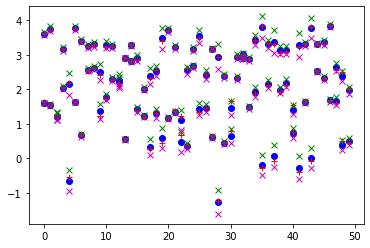

In [11]:
model.eval()
likelihood.eval()
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = Tensor(np.random.random_sample((50,2)))
    predictions = likelihood(model(test_x))
    mean = predictions.mean
    lower, upper = predictions.confidence_region()

plt.plot(mean, 'bo')
plt.plot(vfield_(test_x), 'r+')
plt.plot(upper, 'gx')
plt.plot(lower, 'mx')
plt.show()

In [12]:
print(iter)
print(agg_data.shape)

9
torch.Size([138])


In [13]:
res = 0
res = res + torch.ones(10,10)

In [14]:
print(g_theta2_vec.shape)
print(iter)

torch.Size([98])
9


In [15]:
v2 = g_theta2_vec.reshape((iter)*(loc_size+1) + loc_size,2)
print(vec_x)

tensor([[ 0.0000,  0.0000],
        [-0.0833, -0.6885],
        [-0.0846, -0.0404],
        [ 0.8220,  1.0031],
        [ 0.8729,  0.6876],
        [ 0.8772,  0.6131],
        [ 0.8711,  0.5812],
        [ 2.4345,  2.1809],
        [ 0.4256,  0.1986],
        [ 0.8730,  0.5741]])


In [32]:
print(v2)
np.savetxt('g_theta2_sameopti_4_good.txt', v2.detach().numpy())

tensor([[ 0.7285, -0.4884],
        [ 0.0371,  2.6664],
        [ 2.8064, -1.9296],
        [ 1.6127,  0.6933],
        [ 1.2206, -0.8841],
        [ 0.0293,  3.5004],
        [ 7.2927, -4.0165],
        [ 4.6007,  1.0178],
        [-0.0833, -0.6885],
        [-4.1826, -1.9002],
        [-3.0112, -3.6363],
        [ 2.5766, -1.2720],
        [-7.3657,  5.0935],
        [-0.0846, -0.0404],
        [-0.8263,  0.2095],
        [-0.1379, -2.8568],
        [ 1.3716,  1.7946],
        [ 0.7132,  1.8933],
        [ 0.8220,  1.0031],
        [-0.3453, -2.3797],
        [-2.1266,  2.9145],
        [ 2.9633,  1.6431],
        [-1.5558, -2.7912],
        [ 0.8729,  0.6876],
        [ 2.5314, -0.3233],
        [-0.7090, -1.8506],
        [ 2.3980,  0.6432],
        [-1.8829,  2.1789],
        [ 0.8772,  0.6131],
        [ 1.2253,  1.5062],
        [ 1.2839, -2.0039],
        [ 0.6191,  2.2347],
        [-0.3840,  1.0491],
        [ 0.8711,  0.5812],
        [ 0.8220, -0.5275],
        [-2.0038, -1

In [17]:
np.savetxt('vec_x_sameopti_4_good.txt', vec_x.detach().numpy())

In [18]:
class design_opti_pll(nn.Module):
    def __init__(self, x):
        super(design_opti_pll, self).__init__()
        #loc = np.random.random_sample((loc_size,2))
        #self.g_theta2 = nn.Parameter(Tensor(sample))
        self.x_design = nn.Parameter(Tensor(x))
    def forward(self):
       
        #g_theta2_new = self.g_theta2 #filter_sample(self.g_theta2, 0.009)
        
        return self.x_design

In [19]:
def conduct_design_pll(x0,f_target, g_theta, agg_data, model, likelihood, training_design_iter, training_param_iter, lr_new):
    design = design_opti_pll(x0)
    loc_sample0 = loc_sample
    x_d = design.forward()
    def closure():
        optimizer.zero_grad()
        
        loss2,lower_bound, upper_bound = likelihood.get_pll(f_target,x_d, g_theta, agg_data, model, likelihood)
        #loss2 = -1. * loss2
        loss2.backward(retain_graph=True)
#         print(x_d)
#         print(lower_bound)
#         print(upper_bound)
       
        return loss2
        
        
        
    optimizer = torch.optim.LBFGS(design.parameters(), lr=lr_new, history_size=100, max_iter=100, line_search_fn="strong_wolfe")
    optimizer.step(closure)

    x_d = design.forward()
    loss2,lower_bound, upper_bound = likelihood.get_pll(f_target,x_d, g_theta, agg_data, model, likelihood)
    #loss2 = -1. * loss2
    print('Loss design: %.3f' % ( loss2))
   # print(optimizer.state_dict())
    print(x_d)
    return x_d, lower_bound, upper_bound

In [20]:
# iter_hp = 30
# iter_design = 40 
# iter_param = 50
# num_base_kernels = 3

# f_target = Tensor(vf.tgt_vec) 
# f_target = f_target.reshape(f_target.shape[0],1) 
# tol_vector = 0.005 * torch.ones(f_target.shape)


loc_size_rdn = (iter + 1)*loc_size + sample_size
loc_size_rdn = 169
loc_sample = high_minus_low  * np.random.random_sample((loc_size_rdn,2)) + vf.low #np.random.random_sample((loc_size_rdn,2))
g_theta_ = (Tensor(loc_sample).clone())
agg_data1 = vfield_(g_theta_)
agg_data1 = agg_data1.flatten()


x0 = Tensor(np.array([0.0,0.0])) 
x0 = x0.reshape(1,2)
x00 = x0 
vec_x_rdn = Tensor(np.array([0.,0.])) 
vec_x_rdn = vec_x_rdn.reshape(1,2)

lr_new = 1.
noise_value = 0.0

SUCCESS = False 
FAILURE = False 
 
tol = 0.009 
print('START HYPERPARAMETERS optimization')
model_rdn, likelihood_rdn = hyper_opti(g_theta_,agg_data1,iter_hp,num_base_kernels,noise_value)

print('END HYPERPARAMETERS optimization')

x0_new,lower_bound, upper_bound = conduct_design_pll(x0,f_target, g_theta_, agg_data1, model_rdn, likelihood_rdn, iter_design, iter_param, lr_new)
print(lower_bound)
print(upper_bound)
print(f_target-tol_vector)
print(f_target+tol_vector)
loc_sample = np.random.random_sample((loc_size_rdn,2))


SUCCESS, FAILURE = stopping_criteria(tol_vector, f_target, lower_bound, upper_bound)


print(x0_new)
sol_rdn = x0_new

START HYPERPARAMETERS optimization
Loss gp: -1.115
inv_quad: 160.416
Loss gp: -0.017
inv_quad: 1528.013
Loss gp: -1.277
inv_quad: 261.302
Loss gp: -1.292
inv_quad: 282.053
Loss gp: -1.330
inv_quad: 242.399


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/gpytorch/utils/cholesky.py:83: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Loss gp: -1.345
inv_quad: 265.314
Loss gp: -1.369
inv_quad: 290.389
Loss gp: -1.387
inv_quad: 320.320
Loss gp: -1.383
inv_quad: 282.695
Loss gp: -1.388
inv_quad: 306.276
Loss gp: -1.393
inv_quad: 305.969
Loss gp: -1.396
inv_quad: 311.265
Loss gp: -1.408
inv_quad: 296.499
Loss gp: -1.422
inv_quad: 263.368
Loss gp: -1.423
inv_quad: 298.015
Loss gp: -1.422
inv_quad: 289.151
Loss gp: -1.422
inv_quad: 295.432
Loss gp: -1.423
inv_quad: 298.492
Loss gp: -1.417
inv_quad: 301.180
Loss gp: -1.269
inv_quad: 280.245
Loss gp: -1.424
inv_quad: 297.816
Loss gp: -1.423
inv_quad: 299.125
Loss gp: -1.422
inv_quad: 297.904
Loss gp: -1.422
inv_quad: 298.644


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/gpytorch/utils/cholesky.py:83: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Loss gp: -1.423
inv_quad: 297.592
Loss gp: -1.421
inv_quad: 300.381
Loss gp: -1.421
inv_quad: 297.698
Convergence reached!
END HYPERPARAMETERS optimization
Loss design: 5892.969
Parameter containing:
tensor([[-0.1152, -0.0328]], requires_grad=True)
tensor([[1.4319],
        [0.6514]], grad_fn=<CopySlices>)
tensor([[1.4821],
        [0.7010]], grad_fn=<CopySlices>)
tensor([[3.0123],
        [3.1217]])
tensor([[3.0223],
        [3.1317]])
Parameter containing:
tensor([[-0.1152, -0.0328]], requires_grad=True)


# TAD Plots and Vizualization

## First we vizualize the target function, namely, the contours of the coordinates of the outputs and its norm.

In [113]:
#sns.set_style('ticks') # darkgrid, white grid, dark, white and ticks
sns.set_theme(style="ticks")
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=16)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=15)    # fontsize of the tick labels
plt.rc('ytick', labelsize=15)    # fontsize of the tick labels
plt.rc('legend', fontsize=15)    # legend fontsize
plt.rc('font', size=15)          # controls default text sizes

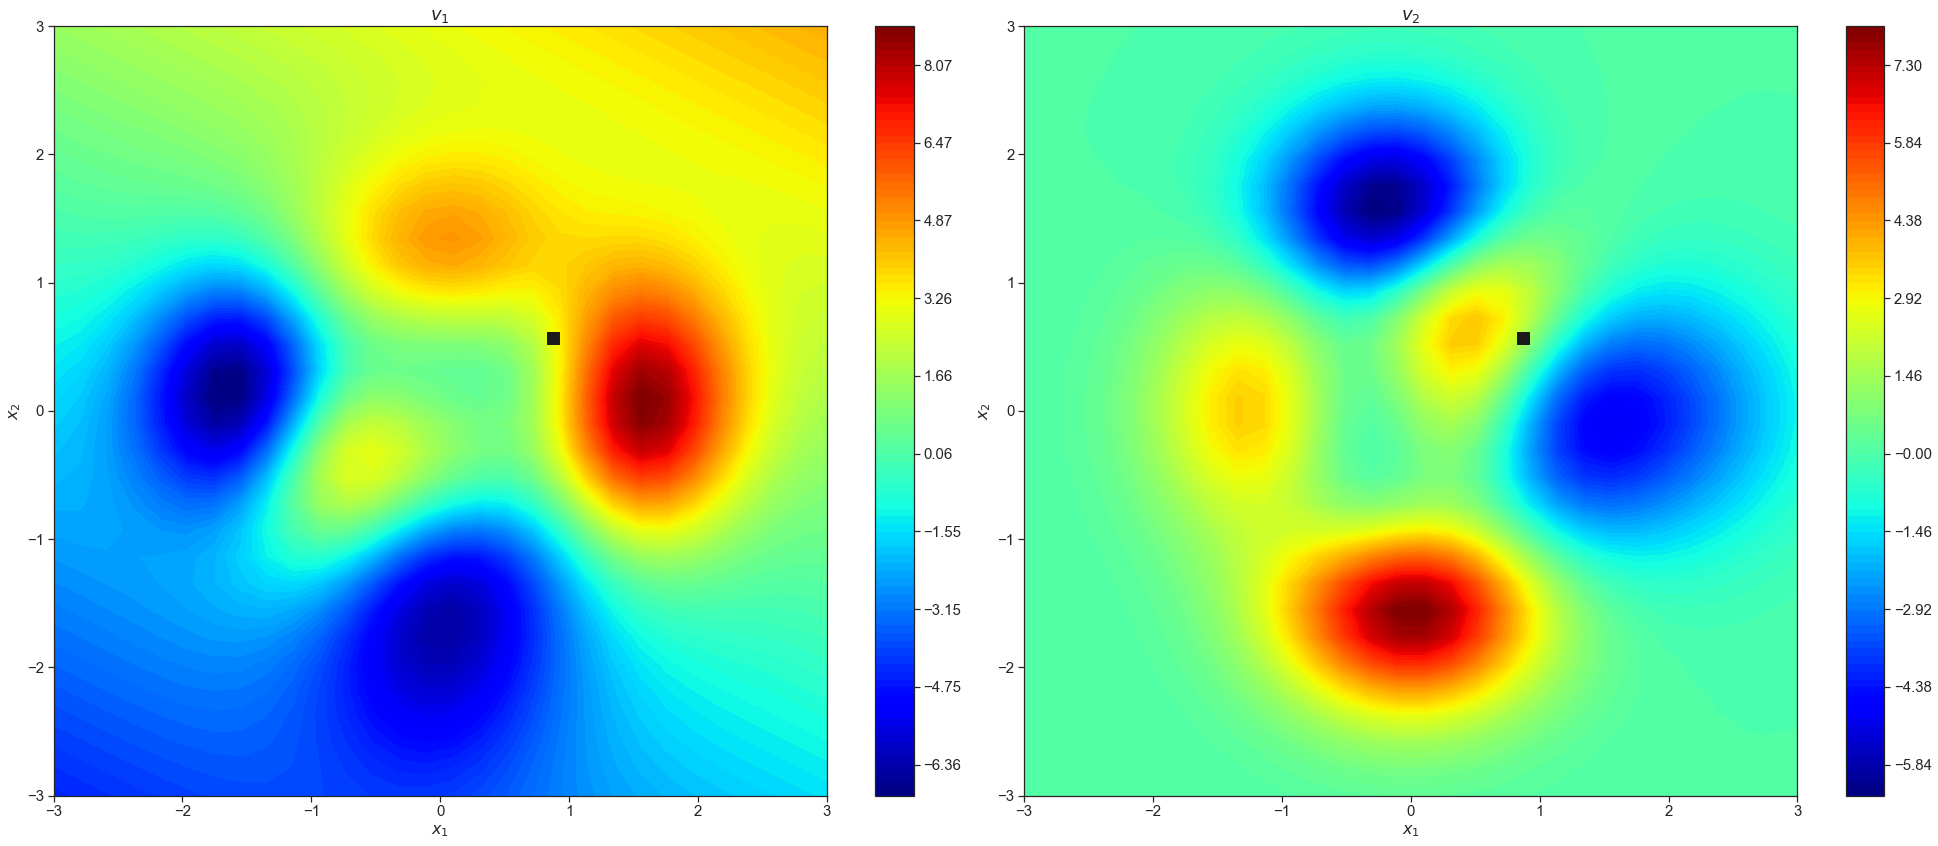

In [114]:
x_plot = np.linspace(vf.low, vf.high, 30)
y_plot = np.linspace(vf.low, vf.high, 30)
xv_plot, yv_plot = np.meshgrid(x_plot, y_plot)
n = x_plot.shape[0]
x_concat = torch.zeros(n * n, 2)
i = 0
k = 0
while i < n*n:
    x_concat[i:i+n,0] = Tensor(xv_plot[:,k])
    x_concat[i:i+n,1] = Tensor(y_plot)
    k = k+1
    i = i+n
out_plot = vfield_(x_concat)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (28, 12),  tight_layout=True)
v_1 = out_plot[:,0].reshape(n,n)
v_2 = out_plot[:,1].reshape(n,n)
v = np.sqrt(v_1**2 + v_2**2)

#pos = ax1.imshow(v_1, cmap='RdGy', interpolation='none')

cs1 = ax1.contourf(xv_plot, yv_plot,v_1, np.linspace(v_1.min(), v_1.max(), 100),cmap='jet')
ax1.plot(vf.tgt_loc[0],vf.tgt_loc[1], 'ks', markersize=12)
#cs11 = ax1.contour(xv_plot, yv_plot, v_1,np.linspace(v_1.min(), v_1.max(), 30),colors='w')
ax1.set_title('$v_1$', fontsize = 18)
ax1.set_xlabel('$x_1$', fontsize = 16)
ax1.set_ylabel('$x_2$', fontsize = 16)
cs2 = ax2.contourf(xv_plot, yv_plot, v_2, np.linspace(v_2.min(), v_2.max(), 100),cmap='jet')
ax2.plot(vf.tgt_loc[0],vf.tgt_loc[1], 'ks', markersize=12)
ax2.set_xlabel('$x_1$', fontsize = 16)
ax2.set_ylabel('$x_2$', fontsize = 16)
#cs21 = ax2.contour(xv_plot, yv_plot, v_2,colors='w')
ax2.set_title('$v_2$', fontsize = 18)
#ax2.set_aspect('equal')
# x = out_plot[:,0]
# y = out_plot[:,1]
# sns.scatterplot(x=out_plot[:,0], y=out_plot[:,1], s=5, color=".15", ax = ax3)    #cs3 = ax3.contourf(xv_plot, yv_plot, v,np.linspace(v.min(), v.max(), 100),cmap='jet')
# sns.histplot(x=x, y=y, bins=50, pthresh=.1, cmap="mako", ax = ax3)
# sns.kdeplot(x=x, y=y, levels=5, color="w", linewidths=1, ax = ax3)

#ax3.plot(vf.tgt_loc[0],vf.tgt_loc[1], 'ks', markersize=12)
# ax3.set_xlabel('$x_1$')
# ax3.set_ylabel('$x_2$')
# #cs31 = ax3.contour(xv_plot, yv_plot, v, np.linspace(v.min(), v.max(), 30),colors='w')
# ax3.set_title('$|v|$')
#ax3.set_aspect('equal')
cbar1 = fig.colorbar(cs1, ax = ax1);
#cbar1.add_lines(cs11)

cbar2 = fig.colorbar(cs2, ax = ax2);
#cbar2.add_lines(cs21)

#cbar3 = fig.colorbar(cs3, ax = ax3);
#cbar3.add_lines(cs31)
# ax01 = fig.add_subplot(3, 2, 2, projection='3d')
# ax02 = fig.add_subplot(3, 2, 4, projection='3d')
# ax03 = fig.add_subplot(3, 2, 6, projection='3d')

# ax01.plot3D(x_concat[:,0], x_concat[:,1], out_plot[:,0])

# ax02.plot3D(x_concat[:,0], x_concat[:,1], out_plot[:,1])



# ax03.plot3D(x_concat[:,0], x_concat[:,1], np.sqrt( (out_plot[:,1])**2 + (out_plot[:,0])**2))
plt.savefig('figures/target_fun.pdf')
plt.show()

# cs = plt.contourf(v_1, levels=[10, 30, 50],
#     colors=['#808080', '#A0A0A0', '#C0C0C0'], extend='both')
# cs.cmap.set_over('red')


In [115]:
print(loc_size_rdn)


169


0
1
4
1
0
9
1
1
14
2
0
19
2
1
24
3
0
29
3
1
34
4
0
39
4
1
44


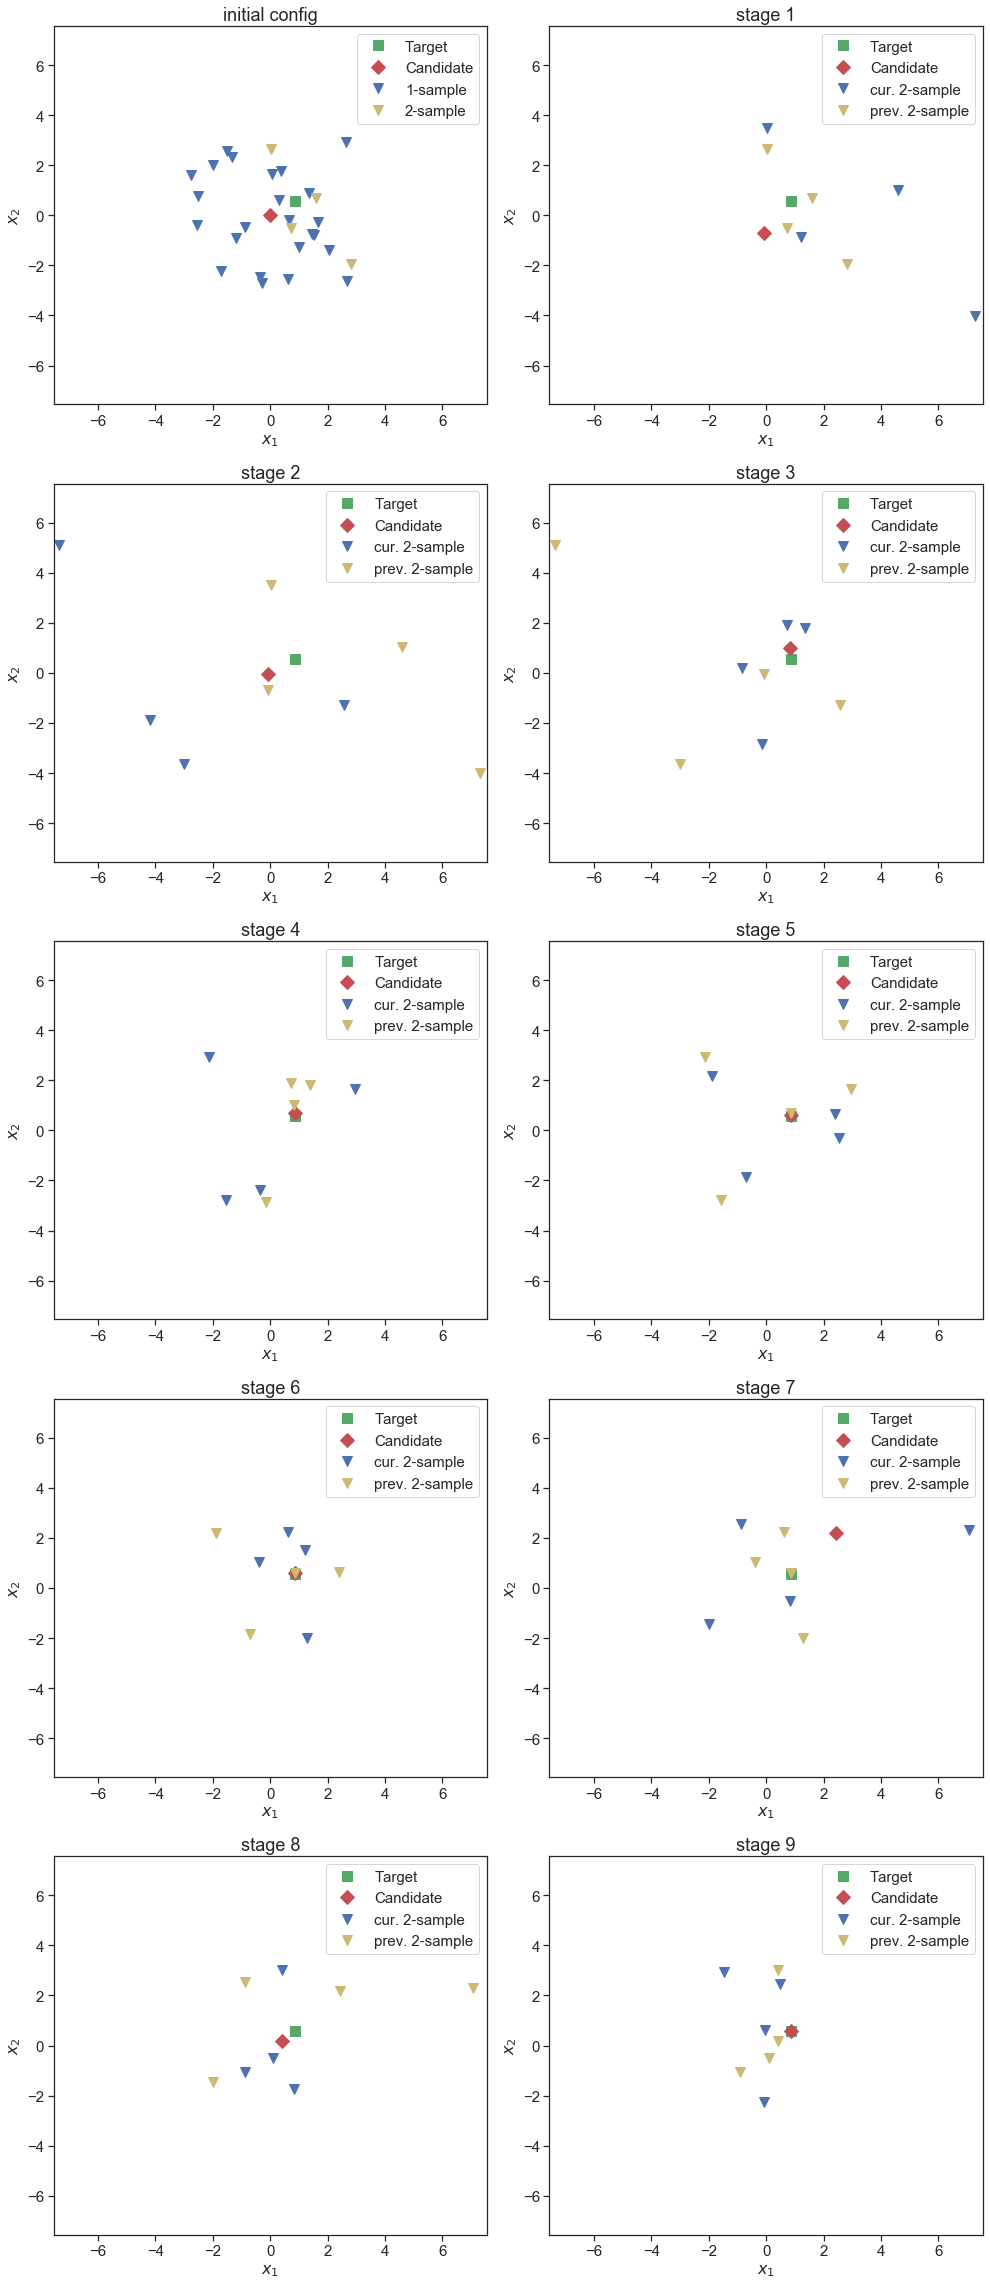

In [154]:
loc_size = 4
i,j=0,0
low = -7.55
high = 7.55
PLOTS_PER_ROW = 2
widths = 16* np.ones((PLOTS_PER_ROW))
heights = 16 * np.ones((math.ceil((iter + 1)/PLOTS_PER_ROW)))
#print(heights)
gs_kw = dict(width_ratios=widths, height_ratios=heights)
#fig, ax = plt.subplots(math.ceil((iter + 1)/PLOTS_PER_ROW),PLOTS_PER_ROW, constrained_layout=True,
#                             gridspec_kw=gs_kw)
fig, axs = plt.subplots(math.ceil((iter+1)/PLOTS_PER_ROW),PLOTS_PER_ROW, figsize=(14, 32), tight_layout=True)
ii = 0
# vec_x = Tensor([[0.5000, 0.7000],
#         [0.1427, 0.2234],
#         [0.1859, 0.1796],
#         [0.2023, 0.0953],
#         [0.1999, 0.0963],
#         [0.2003, 0.0998]])
col = 0

vec_x = vec_x.detach()
axs[i][j].plot(0.8731, 0.5664,'gs',markersize=10)
axs[i][j].plot(vec_x[col,0], vec_x[col,1],'rD',markersize=10)
axs[i][j].plot(x_train.detach()[:,0], x_train.detach()[:,1], 'bv', markersize=10)
axs[i][j].plot(v2.detach()[ii:ii+loc_size,0], v2.detach()[ii:ii+loc_size,1], 'yv', markersize=10)
axs[i][j].set_xlabel('$x_1$')
axs[i][j].set_ylabel('$x_2$')
axs[i][j].set_title('initial config')
axs[i][j].legend(['Target', 'Candidate', '1-sample', '2-sample'])
extent = axs[0][0].get_window_extent().transformed(fig.dpi_scale_trans.inverted())
plt.savefig('figures/initial_config.pdf', bbox_inches=extent.expanded(1.25, 1.25))


#axs[i][j].set_aspect('equal')
if (ii > 0):
    axs[i][j].plot(v2.detach()[(ii-loc_size):ii,0], v2.detach()[ii-loc_size:ii,1], 'yv', markersize=10)
axs[i][j].set_xlim(low, high)
axs[i][j].set_ylim(low, high)

ii = ii+loc_size
j+=1

loc_size = loc_size
for col in range(1, iter+1):
    axs[i][j].plot(0.8731, 0.5664,'gs',markersize=10)
    axs[i][j].plot(vec_x[col,0], vec_x[col,1],'rD',markersize=10)
    axs[i][j].plot(v2.detach()[ii:ii+loc_size,0], v2.detach()[ii:ii+loc_size,1], 'bv', markersize=10)
  #  axs[i][j].set_aspect('equal')
    if (ii >= loc_size):
        axs[i][j].plot(v2.detach()[(ii-loc_size):ii,0], v2.detach()[ii-loc_size:ii,1], 'yv', markersize=10)
    axs[i][j].set_xlim(low, high)
    axs[i][j].set_ylim(low, high)
    axs[i][j].set_xlabel('$x_1$')
    axs[i][j].set_ylabel('$x_2$')
    axs[i][j].set_title('stage %s' % col)
    axs[i][j].legend(['Target', 'Candidate', 'cur. 2-sample', 'prev. 2-sample'])
    print(i)
    print(j)
    print(ii)
    
#     extent = axs[i][j].get_window_extent().transformed(fig.dpi_scale_trans.inverted())
#     name = 'stage %s' % col  + '.pdf'
#     plt.savefig('figures/' + name, bbox_inches=extent.expanded(1.3, 1.3))
    
    ii = ii+loc_size+1
    j+=1
    
    if j%PLOTS_PER_ROW==0:
        i+=1
        j=0
        
        
# extent = axs[0][0].get_window_extent().transformed(fig.dpi_scale_trans.inverted())
# plt.savefig('figures/initial_config.pdf', bbox_inches=extent.expanded(1.25, 1.25))

# extent = axs[0][1].get_window_extent().transformed(fig.dpi_scale_trans.inverted())
# plt.savefig('figures/stage1.pdf', bbox_inches=extent.expanded(1.2, 1.2))

# extent = axs[1][1].get_window_extent().transformed(fig.dpi_scale_trans.inverted())
# plt.savefig('figures/stage3.pdf', bbox_inches=extent.expanded(1.25, 1.25))

# extent = axs[4][1].get_window_extent().transformed(fig.dpi_scale_trans.inverted())
# plt.savefig('figures/final_config.pdf', bbox_inches=extent.expanded(1.25, 1.25))

# plt.savefig('figures/evol_sol.pdf')
plt.show()


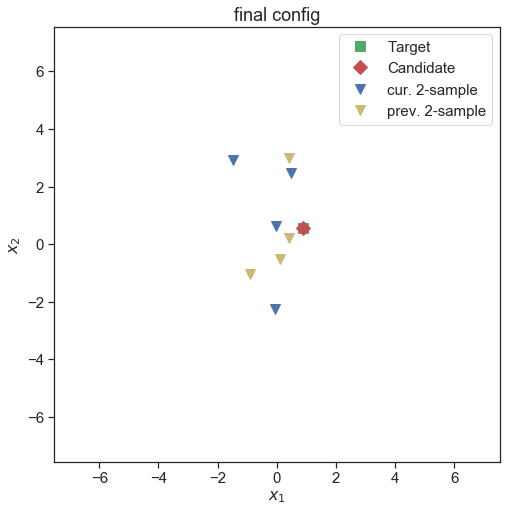

In [163]:
ii = 44
col = 9
f, ax = plt.subplots(figsize=(8, 8))
ax.plot(0.8731, 0.5664,'gs',markersize=10)
ax.plot(vec_x[col,0], vec_x[col,1],'rD',markersize=10)
ax.plot(v2.detach()[ii:ii+loc_size,0], v2.detach()[ii:ii+loc_size,1], 'bv', markersize=10)
ax.plot(v2.detach()[(ii-loc_size):ii,0], v2.detach()[ii-loc_size:ii,1], 'yv', markersize=10)
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_title('final config')
ax.legend(['Target', 'Candidate', 'cur. 2-sample', 'prev. 2-sample'])
ax.set_xlim(low, high)
ax.set_ylim(low, high)
plt.savefig('figures/final_config.pdf')

../vvlikelihood.py:352: GPInputWarning: You have passed data through a FixedNoiseGaussianLikelihood that did not match the size of the fixed noise, *and* you did not specify noise. This is treated as a no-op.
  GPInputWarning,
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/gpytorch/distributions/multivariate_normal.py:263: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.
  NumericalWarning,


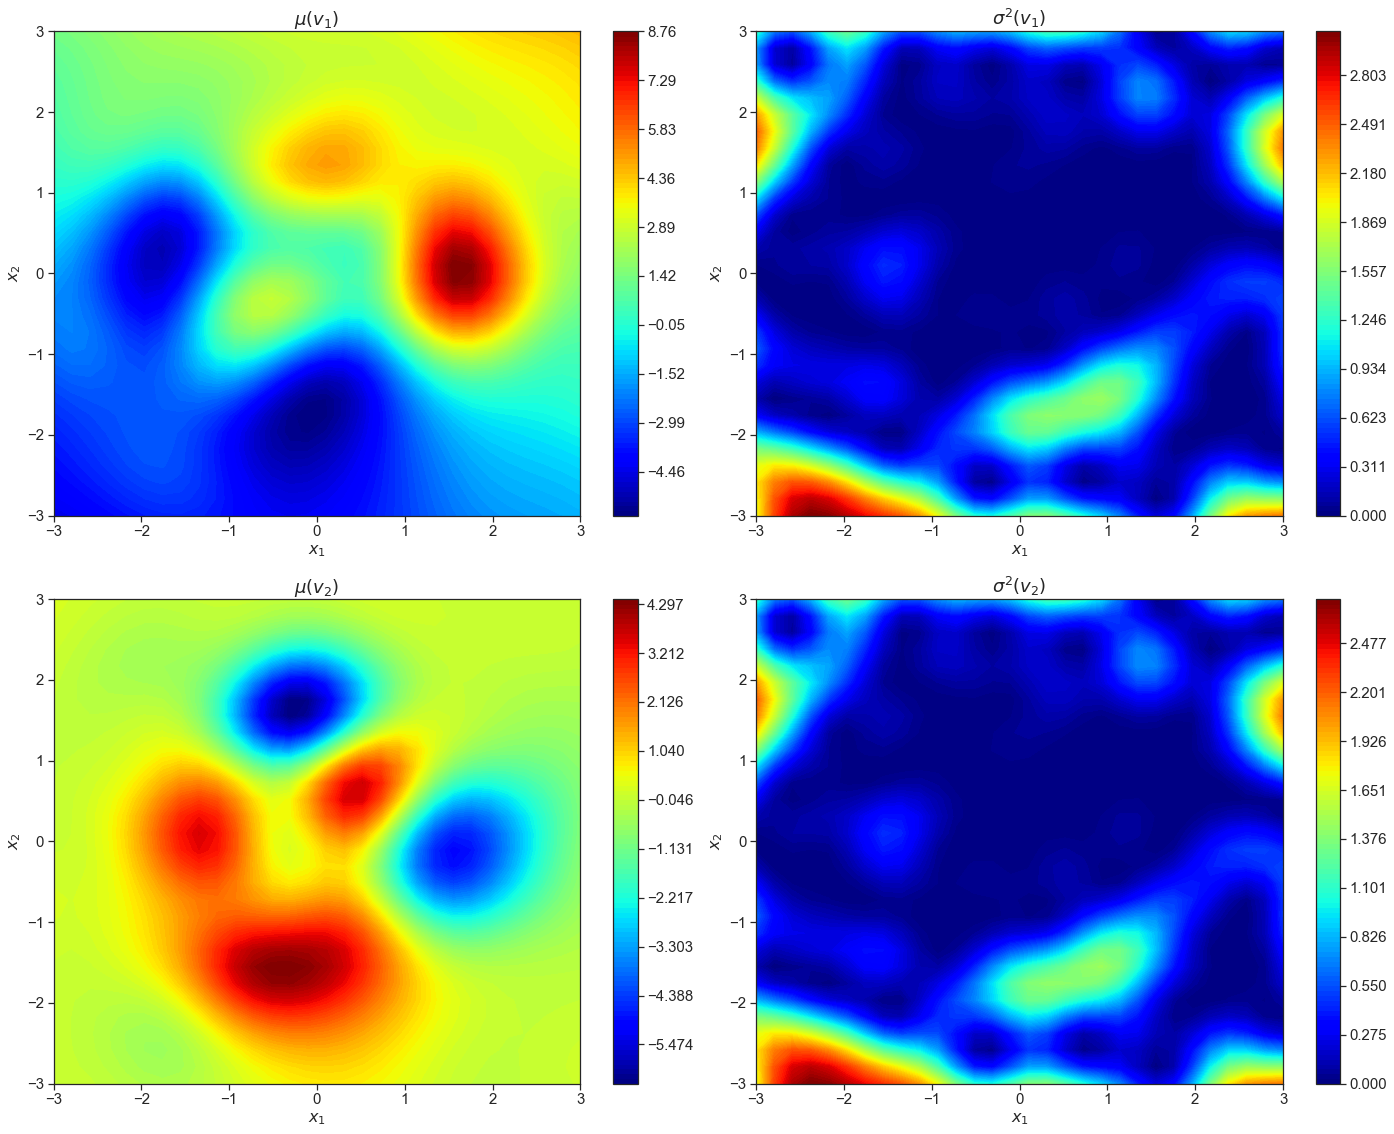

In [125]:
#x0 = Tensor(np.array([0.1937, 0.1257]))
#x0 = Tensor(np.array([0.1885, 0.1038]))
x_plot = np.linspace(vf.low, vf.high, 30)
y_plot = np.linspace(vf.low, vf.high, 30)
xv_plot, yv_plot = np.meshgrid(x_plot, y_plot)
n = x_plot.shape[0]
x_concat_ = torch.zeros(n * n, 2)
i = 0
k = 0
while i < n*n:
    x_concat_[i:i+n,0] = Tensor(xv_plot[:,k])
    x_concat_[i:i+n,1] = Tensor(y_plot)
    k = k+1
    i = i+n
model.eval()
likelihood.eval()

pr = likelihood(model(x_concat_))

mean_v_1 = pr.mean[:,0].reshape(n,n)
mean_v_2 = pr.mean[:,1].reshape(n,n)


var_v_1 = pr.variance[:,0].reshape(n,n)
var_v_2 = pr.variance[:,1].reshape(n,n)

fig, (ax1, ax2) = plt.subplots(2, 2, figsize = (20, 16), tight_layout=True)
cs10 = ax1[0].contourf(xv_plot, yv_plot, mean_v_1.detach(),np.linspace(mean_v_1.detach().min(), mean_v_1.detach().max(), 100), cmap = 'jet')
ax1[0].set_title('$\mu(v_1)$', fontsize = 18)
cbar10 = fig.colorbar(cs10, ax = ax1[0]);

ax1[0].set_xlabel('$x_1$', fontsize = 16)
ax1[0].set_ylabel('$x_2$', fontsize = 16)

cs11 = ax1[1].contourf(xv_plot, yv_plot, var_v_1.detach(), np.linspace(var_v_1.detach().min(), var_v_1.detach().max(), 100), cmap = 'jet')
ax1[1].set_title('$\sigma^2(v_1)$', fontsize = 18)
# ax1[0].set_aspect('equal')
# ax1[1].set_aspect('equal')
cbar11 = fig.colorbar(cs11, ax = ax1[1]);
ax1[1].set_xlabel('$x_1$', fontsize = 16)
ax1[1].set_ylabel('$x_2$', fontsize = 16)


cs20 = ax2[0].contourf(xv_plot, yv_plot, mean_v_2.detach(),np.linspace(mean_v_2.detach().min(), mean_v_2.detach().max(), 100), cmap = 'jet')
ax2[0].set_title('$\mu(v_2)$', fontsize = 18)
cbar20 = fig.colorbar(cs20, ax = ax2[0]);
ax2[0].set_xlabel('$x_1$', fontsize = 16)
ax2[0].set_ylabel('$x_2$', fontsize = 16)



cs21 = ax2[1].contourf(xv_plot, yv_plot, var_v_2.detach(), np.linspace(var_v_2.detach().min(), var_v_2.detach().max(), 100), cmap = 'jet')
ax2[1].set_title('$\sigma^2(v_2)$', fontsize = 18)
cbar21 = fig.colorbar(cs21, ax = ax2[1]);
ax2[1].set_xlabel('$x_1$', fontsize = 16)
ax2[1].set_ylabel('$x_2$', fontsize = 16)


# ax2[0].set_aspect('equal')
# ax2[1].set_aspect('equal')

plt.savefig('figures/mean_var.pdf')


# Grid


In [53]:
loc_size= 4

In [54]:
x_plot = np.linspace(vf.low, vf.high, 15)
y_plot = np.linspace(vf.low, vf.high, 15)
xv_plot, yv_plot = np.meshgrid(x_plot, y_plot)
n = x_plot.shape[0]
x_concat = torch.zeros(n * n, 2)
i = 0
k = 0
while i < n*n:
    x_concat[i:i+n,0] = Tensor(xv_plot[:,k])
    x_concat[i:i+n,1] = Tensor(y_plot)
    k = k+1
    i = i+n

g_theta_grid = x_concat
agg_data1_grid = vfield_(g_theta_grid)
agg_data1_grid = agg_data1_grid.flatten()


x0 = Tensor(np.array([0.0,0.0])) 
x0 = x0.reshape(1,2)
x00 = x0 
vec_x_grid = Tensor(np.array([0.0,0.0])) 
vec_x_grid = vec_x_grid.reshape(1,2)

lr_new = 1.
noise_value = 0.0

SUCCESS = False 
FAILURE = False 
 
tol = 0.009 
print('START HYPERPARAMETERS optimization')
model_grid, likelihood_grid = hyper_opti(g_theta_grid,agg_data1_grid,iter_hp,num_base_kernels,noise_value)

print('END HYPERPARAMETERS optimization')

x0_new,lower_bound, upper_bound = conduct_design_pll(x0,f_target, g_theta_grid, agg_data1_grid, model_grid, likelihood_grid, iter_design, iter_param, lr_new)
print(lower_bound)
print(upper_bound)
print(f_target-tol_vector)
print(f_target+tol_vector)
#loc_sample = np.random.random_sample((loc_size_rdn,2))


SUCCESS, FAILURE = stopping_criteria(tol_vector, f_target, lower_bound, upper_bound)


print(x0_new)

START HYPERPARAMETERS optimization
Loss gp: -1.168
inv_quad: 139.711
Loss gp: 16.300
inv_quad: 17282.328
Loss gp: -1.419
inv_quad: 274.605
Loss gp: -1.398
inv_quad: 522.745
Loss gp: -1.443
inv_quad: 350.173
Loss gp: -1.444
inv_quad: 352.554
Loss gp: -1.499
inv_quad: 267.245
Loss gp: -1.448
inv_quad: 357.993
Loss gp: -1.445
inv_quad: 298.506
Loss gp: -1.432
inv_quad: 272.888
Loss gp: -1.431
inv_quad: 267.852
Loss gp: -1.429
inv_quad: 266.779
Loss gp: -1.430
inv_quad: 266.596
Loss gp: -1.427
inv_quad: 266.523
Loss gp: -1.429
inv_quad: 266.534
Loss gp: -1.426
inv_quad: 266.473
Loss gp: -1.428
inv_quad: 266.579
Loss gp: -1.430
inv_quad: 266.617
Loss gp: -1.430
inv_quad: 266.617
Convergence reached!
END HYPERPARAMETERS optimization
Loss design: 259614.438
Parameter containing:
tensor([[0.0177, 0.2548]], requires_grad=True)
tensor([[0.6632],
        [1.8632]], grad_fn=<CopySlices>)
tensor([[0.6705],
        [1.8698]], grad_fn=<CopySlices>)
tensor([[3.0123],
        [3.1217]])
tensor([[3.0223

Text(41.375, 0.5, '$x_2$')

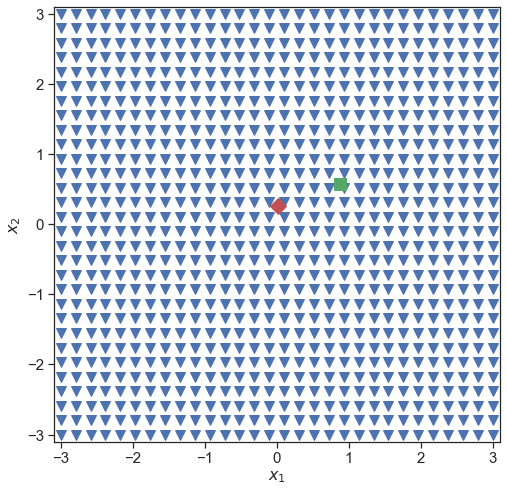

In [164]:
fig, ax = plt.subplots(figsize = (8,8))
ax.plot(x_concat[:,0],x_concat[:,1], 'bv',markersize=10)
ax.plot(x0_new.detach()[0,0], x0_new.detach()[0,1],'rD',markersize=12)
ax.plot(0.8731, 0.5664,'gs',markersize=12)
plt.savefig('figures/grid_sol.pdf')
ax.set_xlim(-3.1, 3.1)
ax.set_ylim(-3.1, 3.1)
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')

Text(41.375, 0.5, '$x_2$')

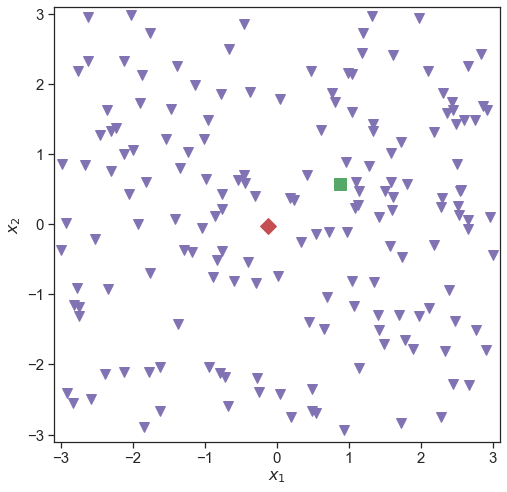

In [165]:
fig, ax = plt.subplots(figsize = (8,8))
ax.plot(g_theta_[:,0].detach(),g_theta_[:,1].detach(), 'mv',markersize=10)
ax.plot(sol_rdn.detach()[0,0], sol_rdn.detach()[0,1],'rD',markersize=12)
ax.plot(0.8731, 0.5664,'gs',markersize=12)
plt.savefig('figures/rdn_sol.pdf')
ax.set_xlim(-3.1, 3.1)
ax.set_ylim(-3.1, 3.1)
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')

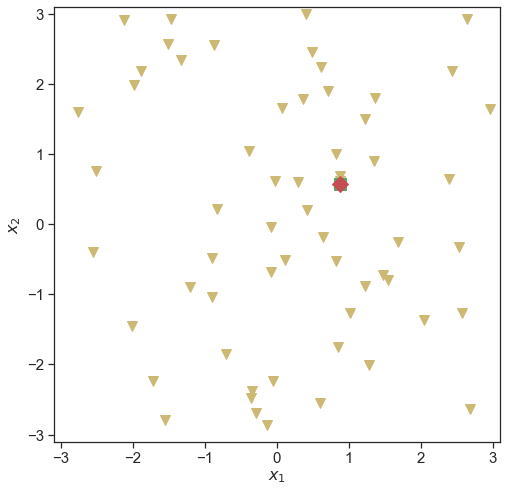

In [166]:
fig, ax = plt.subplots(figsize = (8,8))
ax.set_xlim(-3.1, 3.1)
ax.set_ylim(-3.1, 3.1)
ax.plot(g_theta1[:, 0].detach(),g_theta1[:, 1].detach() , 'yv',markersize=10)
ax.plot(0.8731, 0.5664,'gs',markersize=12)
ax.plot(0.8731, 0.5664,'rD',markersize=12)

ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
plt.savefig('figures/tad_sol_allpoints.pdf')
plt.show()

In [ ]:
 g_theta1.shape[0]

In [ ]:
x0 = Tensor(np.array([0.0,0.0])) 
x0 = x0.reshape(1,2)
print(x0 + 0.001)

In [ ]:
g_theta1.shape

In [ ]:
v2

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="dark")

# Simulate data from a bivariate Gaussian
n = 10000
mean = [0, 0]
cov = [(2, .4), (.4, .2)]
rng = np.random.RandomState(0)
x, y = rng.multivariate_normal(mean, cov, n).T

# Draw a combo histogram and scatterplot with density contours
f, ax = plt.subplots(figsize=(6, 6))
sns.scatterplot(x=x, y=y, s=5, color=".15")
sns.histplot(x=x, y=y, bins=50, pthresh=.1, cmap="mako")
sns.kdeplot(x=x, y=y, levels=5, color="w", linewidths=1)

In [ ]:
print(x)

In [ ]:
x.shape

In [ ]:
v_1.shape

AttributeError: 'AxesSubplot' object has no attribute 'set_box_aspect'

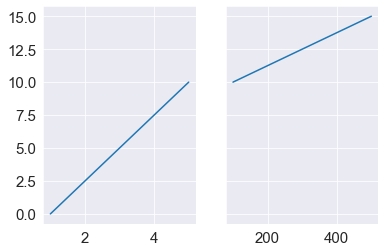